# [Unit 16 附錄A] Chinese MNIST 中文手寫數字辨識實戰 – CNN 基礎入門

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**教材定位**：選讀附錄，建議在 Unit16 主課程前閱讀

**本附錄目標**：
1.  **建立 CNN 模型**：使用 TensorFlow/Keras 建立卷積神經網路 (Convolutional Neural Network)。
2.  **真實數據處理**：學習從 CSV 索引檔與影像檔案加載數據（更貼近實務流程）。
3.  **影像前處理**：了解影像載入、灰階轉換、正規化 (Normalization) 與維度調整。
4.  **模型訓練與評估**：觀察 Accuracy 與 Loss 的學習曲線，並討論過擬合現象。
5.  **結果視覺化**：直觀地查看模型對中文手寫數字的辨識結果。

**資料集介紹**：
Chinese MNIST 中文手寫數字資料集，包含 **15 個類別**（0-9 以及十、百、千、萬、億），共 15,000 張 64×64 灰階影像。
這在化工領域可類比為：
-   產品外觀檢測（瑕疵辨識、多類別分類）。
-   顯微影像中的顆粒或結晶型態分類。
-   多語言/多區域標籤辨識系統。

**與傳統 MNIST 的差異**：
- **類別數更多**：15 類 vs 10 類（包含數量單位）

- **影像更大**：64×64 vs 28×28（特徵更豐富但計算量更高）- **Unit17 (NEU 鋼材缺陷)**: 工業影像檢測完整案例

- **真實數據流程**：需從 CSV + 圖檔加載（非預打包數據集）- **附錄B (Cats vs Dogs)**: 遷移學習實戰

- **文化多樣性**：中文字符辨識（筆畫複雜度差異大）- **本附錄 (Chinese MNIST)**: CNN 基礎概念與真實數據處理

**學習路徑**：

---
# 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit16_Example_ChineseMNIST'
SOURCE_DATA_DIR = 'Chinese_MNIST'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data\Chinese_MNIST
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\figs

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


## 數據下載

In [2]:
# 數據來源: Kaggle Chinese MNIST Dataset
# https://www.kaggle.com/api/v1/datasets/download/gpreda/chinese-mnist

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/gpreda/chinese-mnist"
zip_path = os.path.join(DATA_DIR, "chinese-mnist.zip")
data_file = os.path.join(DATA_DIR, "chinese_mnist.csv")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"檔案已存在於: {data_file}")

檔案已存在於: d:\MyGit\CHE-AI-COURSE\Part_4\data\Chinese_MNIST\chinese_mnist.csv


## 載入必要套件

In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle, json
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(seed=None)
tf.random.set_seed(seed=None)

# 設定matplotlib中文顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.0
Keras版本: 2.10.0


---
## 1. 資料載入與前處理 (Data Loading & Preprocessing)

Chinese MNIST 不像傳統 MNIST 有 Keras 內建函數，我們需要：
1. 從 CSV 檔讀取影像路徑與標籤
2. 載入 JPG 影像並轉為灰階（64×64）

3. 正規化到 0-1 範圍- Code 15: 億 (100000000)

4. 切分訓練/測試集（stratified split 保持類別平衡）- Code 14: 萬 (10000)

- Code 13: 千 (1000)

**類別對照表**：- Code 12: 百 (100)

- Code 1-10: 零、一、二、三、四、五、六、七、八、九- Code 11: 十 (10)

In [4]:
# 載入 Chinese MNIST 資料集（已假設 DATA_DIR, SEED 等變數在其他 cells 已定義）
from PIL import Image

# 讀取 CSV 索引檔
csv_path = DATA_DIR / 'chinese_mnist.csv'
print(f"讀取資料索引: {csv_path}")
df = pd.read_csv(csv_path)

# 影像資料資料夾（資料集結構如原始程式所示）
data_img_dir = DATA_DIR / 'data' / 'data'

# 建立影像路徑欄位
df['image_path'] = df.apply(
    lambda row: data_img_dir / f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg",
    axis=1
)

# 檢查影像檔案是否存在
missing_files = df[~df['image_path'].apply(lambda p: p.exists())]
if len(missing_files) > 0:
    print(f"⚠️ 找不到 {len(missing_files)} 個影像檔案，範例前幾筆：\n", missing_files.head())
else:
    print(f"✓ 所有 {len(df)} 個影像檔案存在")

# 類別名稱與對照（code 1-15 -> label 0-14）
class_names = [
    '零','一','二','三','四','五','六','七','八','九',  # 0-9
    '十','百','千','萬','億'  # 10,100,1000,10000,100000000
]
code_to_label = {i+1: i for i in range(len(class_names))}
label_to_name = {i: class_names[i] for i in range(len(class_names))}

# 載入影像並轉為 NumPy 陣列 (灰階 64x64，正規化到 0-1)
images, labels = [], []
print(f"\n正在載入 {len(df)} 張影像...")
for idx, row in df.iterrows():
    img_path = row['image_path']
    try:
        img = Image.open(img_path).convert('L').resize((64,64))
        img_array = np.array(img, dtype='float32') / 255.0
        images.append(img_array)
        labels.append(code_to_label[int(row['code'])])
    except Exception as e:
        print(f"載入影像失敗: {img_path} -> {e}")
    if (idx + 1) % 3000 == 0:
        print(f"  已載入 {idx + 1}/{len(df)} 張...")

images = np.array(images).reshape(-1, 64, 64, 1)
labels = np.array(labels)
print(f"\n影像陣列形狀: {images.shape}")
print(f"標籤陣列形狀: {labels.shape}")
print(f"像素值範圍: [{images.min():.4f}, {images.max():.4f}]")

# 切分訓練/測試集 (Stratified Split)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print(f"\n資料集切分結果:")
print(f"  訓練集: {train_images.shape}, 標籤: {train_labels.shape}")
print(f"  測試集: {test_images.shape}, 標籤: {test_labels.shape}")

# 訓練集類別分佈
train_unique, train_counts = np.unique(train_labels, return_counts=True)
print(f"\n訓練集類別分佈:")
for label, count in zip(train_unique, train_counts):
    print(f"  {label:2d} - {label_to_name[label]:>2s}: {count:4d} 張 ({count/len(train_labels)*100:.1f}%)")


讀取資料索引: d:\MyGit\CHE-AI-COURSE\Part_4\data\Chinese_MNIST\chinese_mnist.csv
✓ 所有 15000 個影像檔案存在

正在載入 15000 張影像...
  已載入 3000/15000 張...
  已載入 6000/15000 張...
  已載入 9000/15000 張...
  已載入 12000/15000 張...
  已載入 15000/15000 張...

影像陣列形狀: (15000, 64, 64, 1)
標籤陣列形狀: (15000,)
像素值範圍: [0.0000, 1.0000]

資料集切分結果:
  訓練集: (12000, 64, 64, 1), 標籤: (12000,)
  測試集: (3000, 64, 64, 1), 標籤: (3000,)

訓練集類別分佈:
   0 -  零:  800 張 (6.7%)
   1 -  一:  800 張 (6.7%)
   2 -  二:  800 張 (6.7%)
   3 -  三:  800 張 (6.7%)
   4 -  四:  800 張 (6.7%)
   5 -  五:  800 張 (6.7%)
   6 -  六:  800 張 (6.7%)
   7 -  七:  800 張 (6.7%)
   8 -  八:  800 張 (6.7%)
   9 -  九:  800 張 (6.7%)
  10 -  十:  800 張 (6.7%)
  11 -  百:  800 張 (6.7%)
  12 -  千:  800 張 (6.7%)
  13 -  萬:  800 張 (6.7%)
  14 -  億:  800 張 (6.7%)


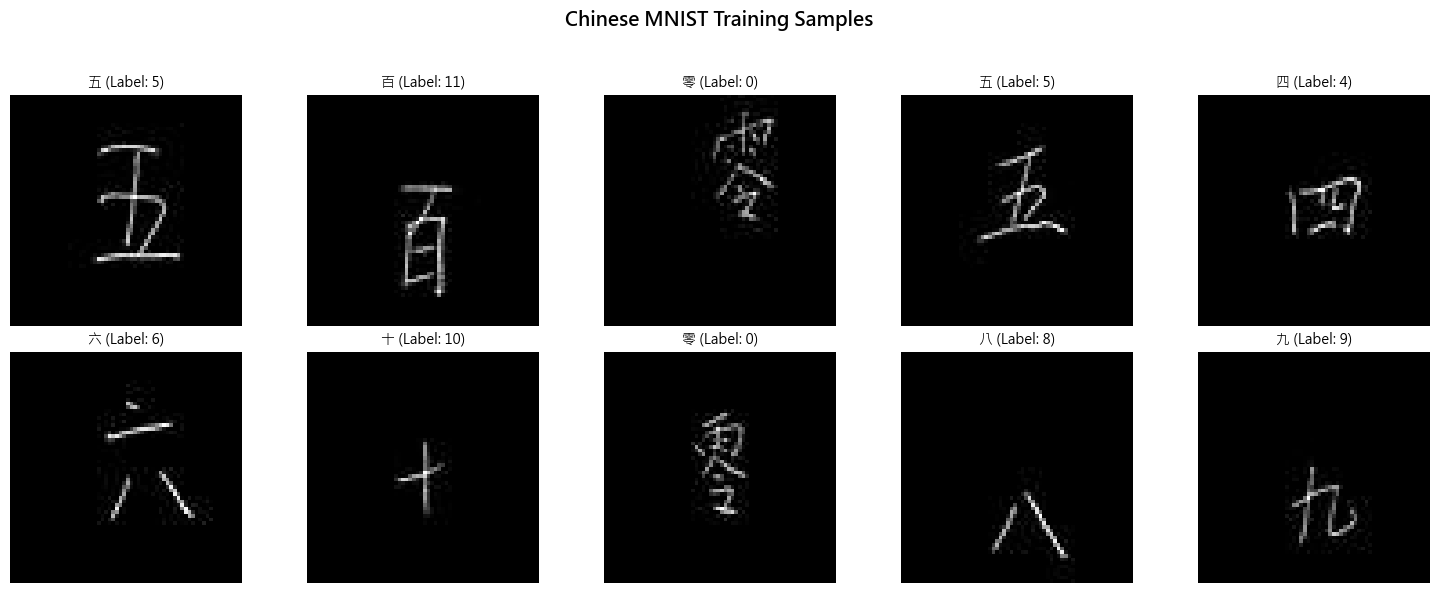

✓ 樣本影像已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\figs\sample_images.png


In [5]:
# ========================================
# 視覺化前 10 張訓練影像
# ========================================
plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(train_images[i].reshape(64, 64), cmap="gray")
    lbl = int(train_labels[i])
    ax.set_title(f"{label_to_name[lbl]} (Label: {lbl})", fontsize=10)
    ax.axis("off")

plt.suptitle("Chinese MNIST Training Samples", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

out_path = FIG_DIR / 'sample_images.png'
plt.savefig(out_path, dpi=100, bbox_inches='tight')
plt.show()
print(f"✓ 樣本影像已儲存至: {out_path}")

### 數據集統計分析

In [6]:
# 數據集基本統計
print("=" * 70)
print("Chinese MNIST 數據集統計摘要")
print("=" * 70)

print(f"\n【數據集規模】")
print(f"  總樣本數: {len(images):,}")
print(f"  訓練集: {len(train_images):,} ({len(train_images)/len(images)*100:.1f}%)")
print(f"  測試集: {len(test_images):,} ({len(test_images)/len(images)*100:.1f}%)")

print(f"\n【影像規格】")
print(f"  影像尺寸: {images.shape[1]}×{images.shape[2]} 像素")
print(f"  通道數: {images.shape[3]} (灰階)")
print(f"  像素值範圍: [{images.min():.2f}, {images.max():.2f}]")
print(f"  資料類型: {images.dtype}")

print(f"\n【類別資訊】")
print(f"  類別數: {len(class_names)}")
print(f"  類別名稱: {', '.join(class_names)}")
print(f"\n  類別分布 (訓練集):")
for i, count in enumerate(train_counts):
    print(f"    {i:2d} - {label_to_name[i]:>2s}: {count:4d} 張 ({count/len(train_labels)*100:.1f}%)")

# 檢查類別平衡度
max_count = train_counts.max()
min_count = train_counts.min()
balance_ratio = max_count / min_count
print(f"\n  類別平衡度: {balance_ratio:.2f} (最多/最少比例，理想值=1.00)")
if balance_ratio <= 1.1:
    print(f"  ✓ 類別分布非常平衡")
elif balance_ratio <= 1.5:
    print(f"  ✓ 類別分布較為平衡")
else:
    print(f"  ⚠️ 類別分布不平衡，建議使用 class_weight 或數據增強")

print("\n" + "=" * 70)

Chinese MNIST 數據集統計摘要

【數據集規模】
  總樣本數: 15,000
  訓練集: 12,000 (80.0%)
  測試集: 3,000 (20.0%)

【影像規格】
  影像尺寸: 64×64 像素
  通道數: 1 (灰階)
  像素值範圍: [0.00, 1.00]
  資料類型: float32

【類別資訊】
  類別數: 15
  類別名稱: 零, 一, 二, 三, 四, 五, 六, 七, 八, 九, 十, 百, 千, 萬, 億

  類別分布 (訓練集):
     0 -  零:  800 張 (6.7%)
     1 -  一:  800 張 (6.7%)
     2 -  二:  800 張 (6.7%)
     3 -  三:  800 張 (6.7%)
     4 -  四:  800 張 (6.7%)
     5 -  五:  800 張 (6.7%)
     6 -  六:  800 張 (6.7%)
     7 -  七:  800 張 (6.7%)
     8 -  八:  800 張 (6.7%)
     9 -  九:  800 張 (6.7%)
    10 -  十:  800 張 (6.7%)
    11 -  百:  800 張 (6.7%)
    12 -  千:  800 張 (6.7%)
    13 -  萬:  800 張 (6.7%)
    14 -  億:  800 張 (6.7%)

  類別平衡度: 1.00 (最多/最少比例，理想值=1.00)
  ✓ 類別分布非常平衡



---
## 2. 建立 CNN 模型 (Build CNN Model)

我們將建立一個適合 64×64 影像的卷積神經網路，包含：
1.  **特徵提取層 (Feature Extraction)**：
    -   `Conv2D`：卷積層，負責提取影像特徵（如邊緣、紋理、筆畫）。
    -   `MaxPooling2D`：池化層，負責降低維度並保留重要特徵。
2.  **分類層 (Classification Head)**：
    -   `Flatten`：將二維特徵圖展平為一維向量。
    -   `Dense` + `Dropout`：全連接層負責最後的分類決策，Dropout 防止過擬合。

- 輸出類別：10 類 → 15 類

**與 MNIST 模型的差異**：- 卷積層數：2 層 → 3 層（更深的特徵提取）
- 輸入尺寸：28×28 → 64×64（4倍像素）

In [7]:
model = Sequential()

# --- 特徵提取層 ---
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))  # 64 -> 32

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))  # 32 -> 16

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))  # 16 -> 8

# --- 分類層 ---
model.add(Flatten())  # 8x8x128 = 8192 維
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="softmax"))  # 15 類別

# 顯示模型架構與參數量
model.summary()
total_params = model.count_params()
print(f"原因: 64x64 影像比 28x28 大 {64*64/(28*28):.1f} 倍，需要更多參數提取特徵")
print(f"比較: MNIST 模型約 400K 參數, Chinese MNIST 約 {total_params/1e6:.1f}M 參數")
print(f"\n模型總參數量: {total_params:,}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

---
## 3. 模型訓練 (Training)

我們使用 `adam` 優化器與 `sparse_categorical_crossentropy` 損失函數。
訓練過程中，我們會保留 10% 的資料作為驗證集 (Validation Set)，用來監控模型是否過擬合。

- Epochs 減少：5 個 epoch 即可達到良好效果

**與 MNIST 的差異**：- Batch size 調小：64 vs 128（適應小數據集）
- 數據量較少：12,000 訓練樣本 vs MNIST 60,000

In [8]:
# 編譯模型
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# 設定訓練參數
epochs = 10  # Chinese MNIST 需要更多 epoch（數據量較少）
batch_size = 64  # 調小 batch size

print(f"開始訓練模型 ({epochs} epochs, batch_size={batch_size})...")
print(f"訓練集大小: {len(train_images)} 張")
print(f"每 epoch 約 {len(train_images) // batch_size} 個 batch\n")

history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1, # 使用 10% 訓練資料做驗證
    verbose=1,
)
print("訓練完成！")

開始訓練模型 (10 epochs, batch_size=64)...
訓練集大小: 12000 張
每 epoch 約 187 個 batch

Epoch 1/10
169/169 [==============================] - 2s 7ms/step - loss: 1.4031 - accuracy: 0.5464 - val_loss: 0.4249 - val_accuracy: 0.8533
Epoch 2/10
169/169 [==============================] - 1s 6ms/step - loss: 0.4729 - accuracy: 0.8375 - val_loss: 0.2051 - val_accuracy: 0.9383
Epoch 3/10
169/169 [==============================] - 1s 6ms/step - loss: 0.2800 - accuracy: 0.9061 - val_loss: 0.1289 - val_accuracy: 0.9625
Epoch 4/10
169/169 [==============================] - 1s 6ms/step - loss: 0.2008 - accuracy: 0.9348 - val_loss: 0.1146 - val_accuracy: 0.9600
Epoch 5/10
169/169 [==============================] - 1s 6ms/step - loss: 0.1644 - accuracy: 0.9445 - val_loss: 0.0653 - val_accuracy: 0.9833
Epoch 6/10
169/169 [==============================] - 1s 6ms/step - loss: 0.1261 - accuracy: 0.9567 - val_loss: 0.0664 - val_accuracy: 0.9750
Epoch 7/10
169/169 [==============================] - 1s 6ms/step - loss:

---
## 4. 學習曲線 (Learning Curves)

觀察 Accuracy 與 Loss 隨 Epoch 的變化，可以幫助我們判斷模型訓練狀況。
-   **正常**：Training 與 Validation 的 Accuracy 同步上升，Loss 同步下降。
-   **過擬合 (Overfitting)**：Training Accuracy 很高，但 Validation Accuracy 卡住甚至下降。

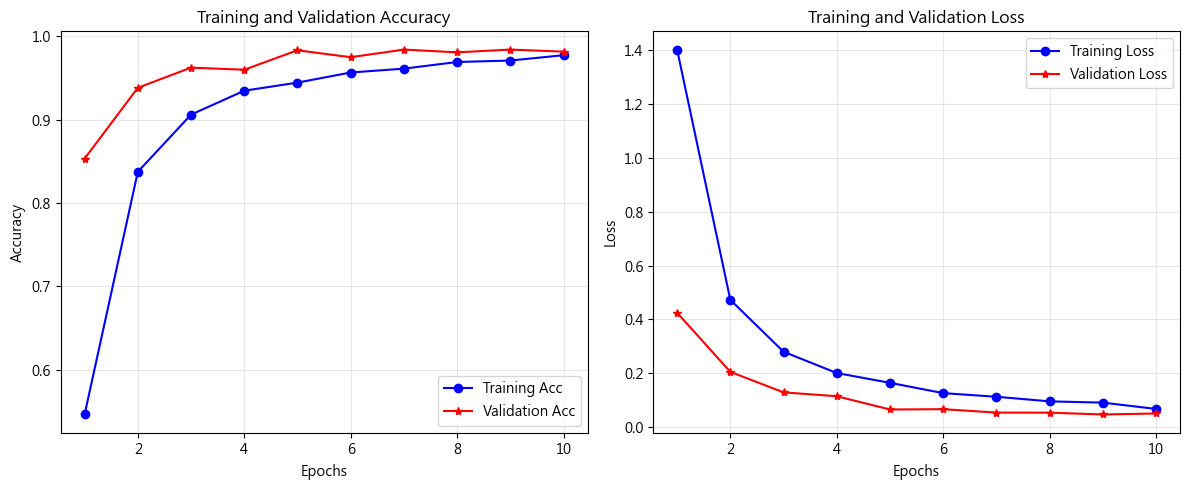

In [9]:
# 取得訓練歷史數據
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 繪製 Accuracy 曲線
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, "bo-", label="Training Acc")
plt.plot(epochs_range, val_acc, "r*-", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# 繪製 Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "bo-", label="Training Loss")
plt.plot(epochs_range, val_loss, "r*-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'learning_curves.png')
plt.show()

---
## 5. 預測結果展示 (Predictions)

最後，我們使用測試集來評估模型的最終表現，並視覺化部分預測結果。

94/94 - 0s - loss: 0.0633 - accuracy: 0.9857 - 310ms/epoch - 3ms/step

Test accuracy: 0.9857 (98.57%)
Test loss: 0.0633

正在進行預測...
94/94 [==============================] - 0s 2ms/step
✓ 完成 3000 張影像的預測


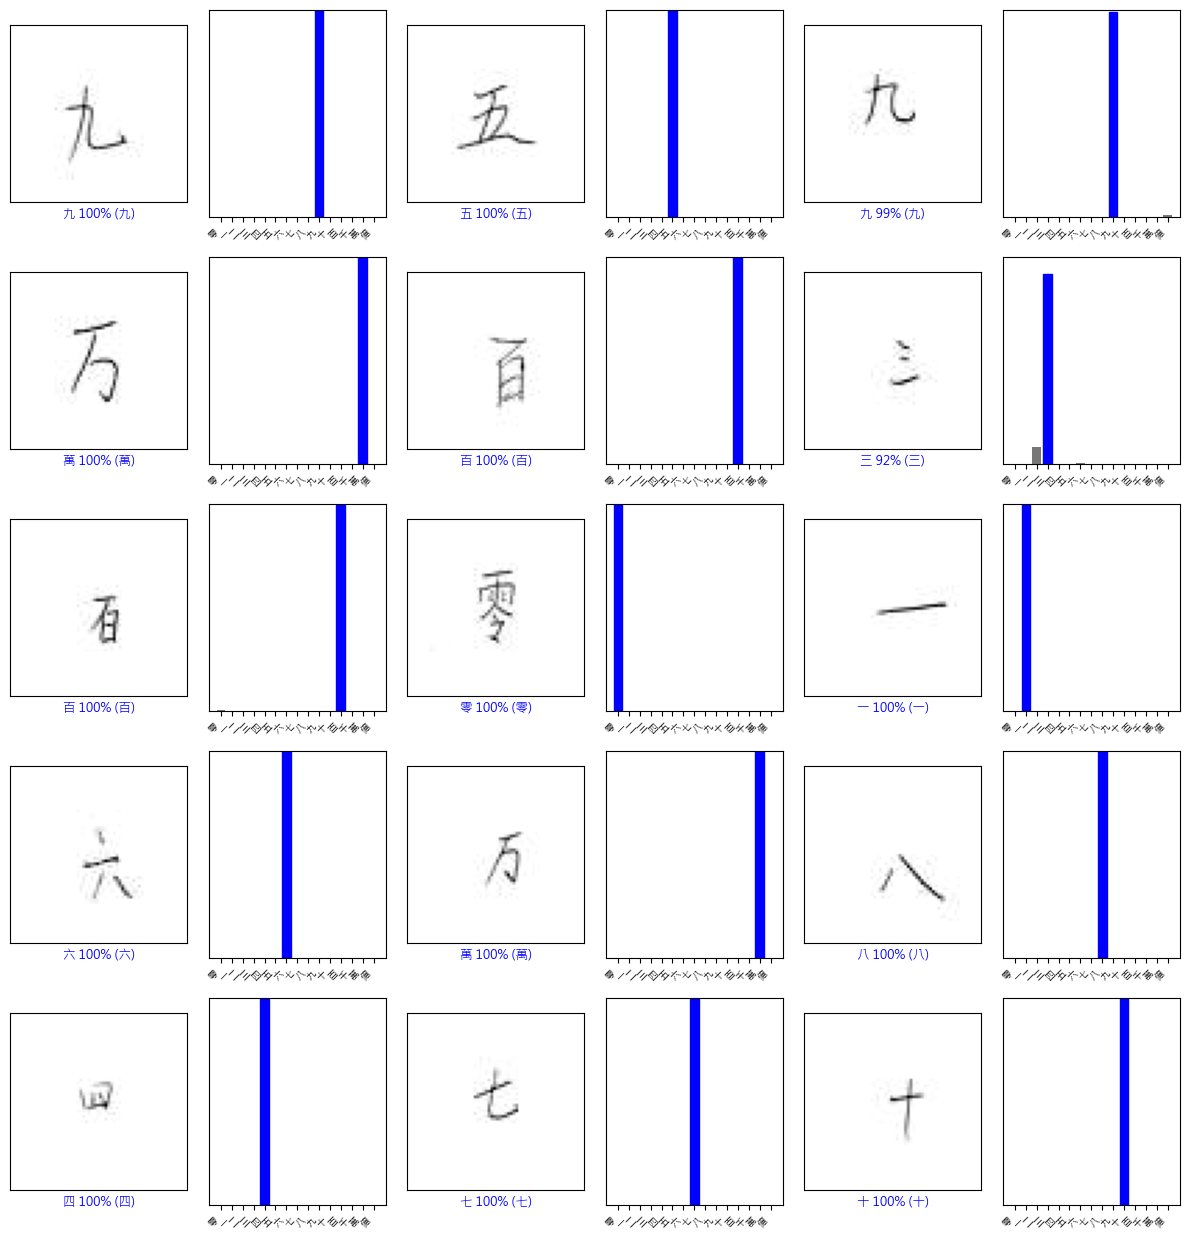


✓ 預測結果已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\figs\predictions.png


In [10]:
# 評估模型
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

# 進行預測
print("\n正在進行預測...")
predictions = model.predict(test_images)
predictions = np.array(predictions)
print(f"✓ 完成 {len(predictions)} 張影像的預測")

# 視覺化預測結果
def plot_image(i, pred_array, true_labels, images):
  true_label = int(true_labels[i])
  img = images[i].reshape(64, 64)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = int(np.argmax(pred_array))
  color = 'blue' if predicted_label == true_label else 'red'

  pred_name = label_to_name[predicted_label]
  true_name = label_to_name[true_label]
  confidence = 100 * np.max(pred_array)
  plt.xlabel(f"{pred_name} {confidence:.0f}% ({true_name})", color=color, fontsize=9)

def plot_value_array(i, pred_array, true_labels):
  true_label = int(true_labels[i])
  plt.grid(False)
  plt.xticks(range(15), [label_to_name[j] for j in range(15)], rotation=45, ha='right', fontsize=7)
  plt.yticks([])
  bars = plt.bar(range(15), pred_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = int(np.argmax(pred_array))
  bars[predicted_label].set_color('red')
  bars[true_label].set_color('blue')

# 顯示前 15 張圖的預測結果
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
num_images = min(num_images, len(test_images))

plt.figure(figsize=(2*2*num_cols, 2.5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(i, predictions[i], test_labels, test_images)

  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_value_array(i, predictions[i], test_labels)

plt.tight_layout()
out_path = FIG_DIR / 'predictions.png'
plt.savefig(out_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ 預測結果已儲存至: {out_path}")


---
## 6. 混淆矩陣分析 (Confusion Matrix Analysis)

混淆矩陣可以幫助我們了解模型在哪些類別之間容易混淆，找出改進方向。

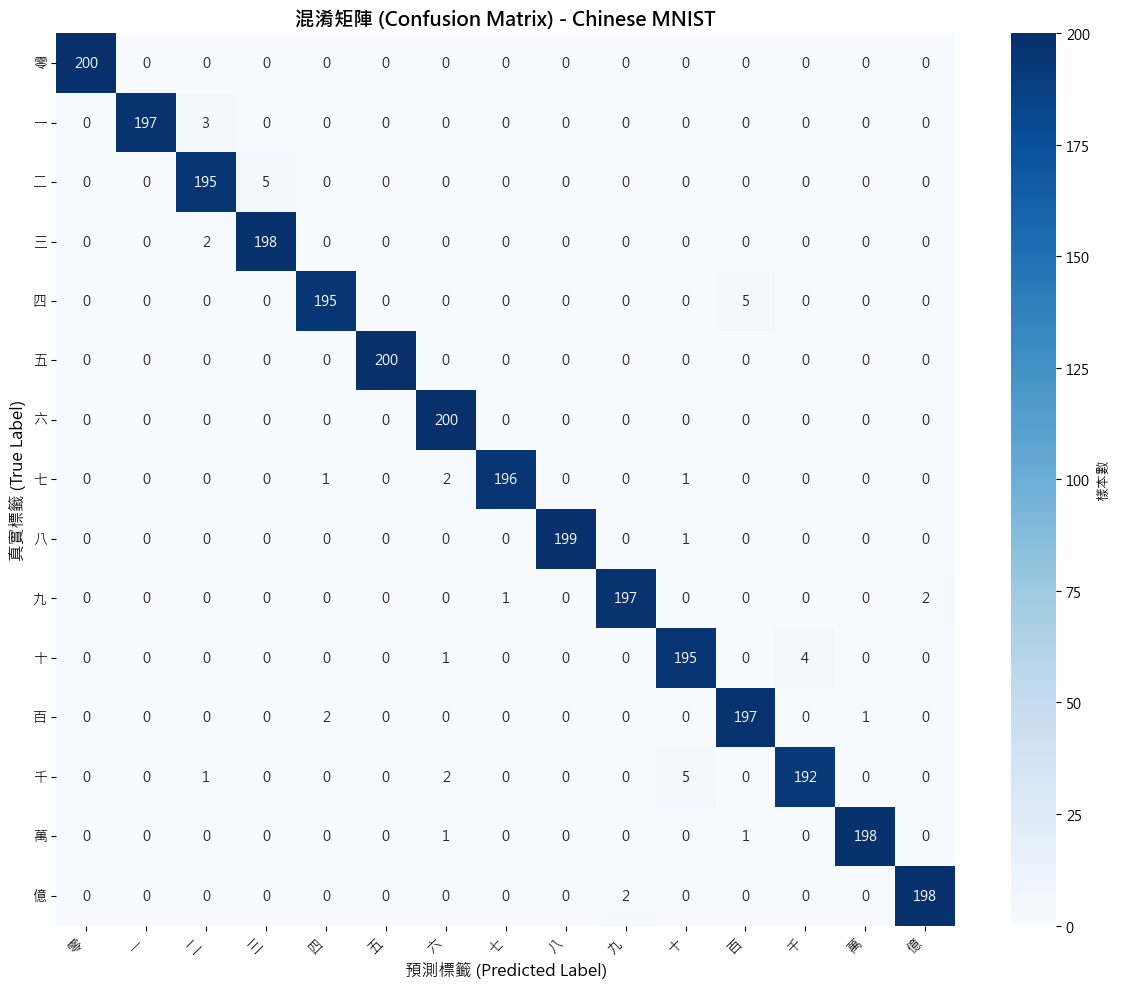

✓ 混淆矩陣已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\figs\confusion_matrix.png

最容易混淆的類別對（非對角線元素）:
   1. '二' 被誤判為 '三': 5 次
   2. '四' 被誤判為 '百': 5 次
   3. '千' 被誤判為 '十': 5 次
   4. '十' 被誤判為 '千': 4 次
   5. '一' 被誤判為 '二': 3 次
   6. '三' 被誤判為 '二': 2 次
   7. '七' 被誤判為 '六': 2 次
   8. '九' 被誤判為 '億': 2 次
   9. '百' 被誤判為 '四': 2 次
  10. '千' 被誤判為 '六': 2 次

詳細分類報告:
              precision    recall  f1-score   support

           零     1.0000    1.0000    1.0000       200
           一     1.0000    0.9850    0.9924       200
           二     0.9701    0.9750    0.9726       200
           三     0.9754    0.9900    0.9826       200
           四     0.9848    0.9750    0.9799       200
           五     1.0000    1.0000    1.0000       200
           六     0.9709    1.0000    0.9852       200
           七     0.9949    0.9800    0.9874       200
           八     1.0000    0.9950    0.9975       200
           九     0.9899    0.9850    0.9875       200
           十     0.9653    0.

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 生成預測標籤
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# 繪製混淆矩陣
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_to_name[i] for i in range(15)],
            yticklabels=[label_to_name[i] for i in range(15)],
            cbar_kws={'label': '樣本數'})
plt.title('混淆矩陣 (Confusion Matrix) - Chinese MNIST', fontsize=14, fontweight='bold')
plt.ylabel('真實標籤 (True Label)', fontsize=12)
plt.xlabel('預測標籤 (Predicted Label)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

out_path = FIG_DIR / 'confusion_matrix.png'
plt.savefig(out_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"✓ 混淆矩陣已儲存至: {out_path}")

# 找出最容易混淆的類別對
print("\n最容易混淆的類別對（非對角線元素）:")
confusion_pairs = []
for i in range(15):
    for j in range(15):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

# 排序並顯示前 10 個
confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for rank, (true_lbl, pred_lbl, count) in enumerate(confusion_pairs[:10], 1):
    true_name = label_to_name[true_lbl]
    pred_name = label_to_name[pred_lbl]
    print(f"  {rank:2d}. '{true_name}' 被誤判為 '{pred_name}': {count} 次")

# 詳細分類報告
print("\n詳細分類報告:")
print("=" * 70)
report = classification_report(y_true, y_pred, 
                               target_names=[label_to_name[i] for i in range(15)],
                               digits=4)
print(report)

---
## 7. 結果驗證與圖片檢查

驗證所有輸出圖片是否正確生成。

In [12]:
# ========================================
# 驗證所有輸出圖片
# ========================================
print("=" * 70)
print("圖片生成狀態檢查")
print("=" * 70)

expected_files = [
    ('sample_images.png', 'Section 2.1: 訓練樣本展示'),
    ('learning_curves.png', 'Section 2.4: 學習曲線'),
    ('predictions.png', 'Section 2.5: 預測結果'),
    ('confusion_matrix.png', 'Section 4.1: 混淆矩陣')
]

print(f"\n圖片輸出目錄: {FIG_DIR}\n")

all_exist = True
for filename, description in expected_files:
    path = FIG_DIR / filename
    if path.exists():
        size_kb = path.stat().st_size / 1024
        print(f"  ✓ {filename:25s} {size_kb:6.1f} KB  [{description}]")
    else:
        print(f"  ✗ {filename:25s}  缺失！  [{description}]")
        all_exist = False

if all_exist:
    print(f"\n✓ 所有圖片生成成功！")
    print(f"  講義 Unit16_Appendix_MNIST.md 可正確引用這些圖片。")
else:
    print(f"\n⚠️ 部分圖片未生成，請檢查上方 cell 是否正確執行。")

print("\n" + "=" * 70)

# ========================================
# 模型總結
# ========================================
print("\n" + "=" * 70)
print("訓練總結")
print("=" * 70)

print(f"\n【模型架構】")
print(f"  輸入尺寸: 64×64×1")
print(f"  卷積層數: 3 層 (32 → 64 → 128 filters)")
print(f"  全連接層: 128 neurons + Dropout(0.5)")
print(f"  輸出層: 15 classes (Softmax)")
print(f"  總參數量: {model.count_params():,}")

print(f"\n【訓練配置】")
print(f"  訓練樣本: {len(train_images):,}")
print(f"  測試樣本: {len(test_images):,}")
print(f"  Epochs: {epochs}")
print(f"  Batch Size: {batch_size}")
print(f"  Optimizer: Adam")
print(f"  Loss: Sparse Categorical Crossentropy")

print(f"\n【最終表現】")
print(f"  測試準確率: {test_acc*100:.2f}%")
print(f"  測試損失: {test_loss:.4f}")

# 計算每個類別的準確率
class_correct = np.zeros(15)
class_total = np.zeros(15)
for i in range(len(test_labels)):
    label = test_labels[i]
    class_total[label] += 1
    if y_pred[i] == label:
        class_correct[label] += 1

print(f"\n【各類別準確率】")
for i in range(15):
    acc = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0
    print(f"  {label_to_name[i]:>2s}: {acc:5.1f}%  ({int(class_correct[i])}/{int(class_total[i])})")

print("\n" + "=" * 70)
print("✓ Chinese MNIST 訓練與評估完成！")
print("=" * 70)

圖片生成狀態檢查

圖片輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_ChineseMNIST\figs

  ✓ sample_images.png           37.7 KB  [Section 2.1: 訓練樣本展示]
  ✓ learning_curves.png         50.5 KB  [Section 2.4: 學習曲線]
  ✓ predictions.png            113.8 KB  [Section 2.5: 預測結果]
  ✓ confusion_matrix.png        64.9 KB  [Section 4.1: 混淆矩陣]

✓ 所有圖片生成成功！
  講義 Unit16_Appendix_MNIST.md 可正確引用這些圖片。


訓練總結

【模型架構】
  輸入尺寸: 64×64×1
  卷積層數: 3 層 (32 → 64 → 128 filters)
  全連接層: 128 neurons + Dropout(0.5)
  輸出層: 15 classes (Softmax)
  總參數量: 1,143,311

【訓練配置】
  訓練樣本: 12,000
  測試樣本: 3,000
  Epochs: 10
  Batch Size: 64
  Optimizer: Adam
  Loss: Sparse Categorical Crossentropy

【最終表現】
  測試準確率: 98.57%
  測試損失: 0.0633

【各類別準確率】
   零: 100.0%  (200/200)
   一:  98.5%  (197/200)
   二:  97.5%  (195/200)
   三:  99.0%  (198/200)
   四:  97.5%  (195/200)
   五: 100.0%  (200/200)
   六: 100.0%  (200/200)
   七:  98.0%  (196/200)
   八:  99.5%  (199/200)
   九:  98.5%  (197/200)
   十:  97.5%  (195/200)
   百:  98.5%  (197/20